# MovIA: Proyecto desarrollo de un Sistema de Recomendación de Películas con IA

## Fase 1: Preparación del Entorno y Datos

In [43]:
# Importación de bibliotecas necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import spacy
from nltk.stem import PorterStemmer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
# Para mostrar todas las filas y/o columnas del DataFrame
pd.options.display.max_columns = None
#pd.options.display.max_rows = None

In [3]:
# Lectura de los DataSets
df_credits = pd.read_csv('tmdb_5000_credits.csv')
df_movies = pd.read_csv('tmdb_5000_movies.csv')
print(df_credits.columns)
print(df_movies.columns)

Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')
Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')


In [4]:
# Se cambia la columna 'movie_id' del DataFrame df_credits a 'id' para poder hacer un merge posteriormente
df_credits.columns = ['id', 'title', 'cast', 'crew']

# Se elimina la columna 'title' ya que está en ambos DataFrames y aparecería duplicada una vez se haga el merge
df_credits.drop(['title'], axis=1, inplace=True)
df_credits.head()

,id,cast,crew
0,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [5]:
# Se hace el merge
df_merge = df_movies.merge(df_credits, on='id')
df_merge.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


## Fase 2: Análisis Exploratorio de Datos (EDA) y Procesamiento del Lenguaje Natural (NLP)

### EDA

In [6]:
# Tamaño del DataFrame
df_merge.shape

(4803, 22)

In [7]:
df_merge.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


df_merge.info()

#### Revisión de nulos

In [8]:
# Cantidad de nulos

null_counts = df_merge.isnull().sum()
print("Número de valores nulos por columna:")
print(null_counts[null_counts > 0])

Número de valores nulos por columna:
homepage        3091
overview           3
release_date       1
runtime            2
tagline          844
dtype: int64


- *homepage*: Se eiminará dicha columna ya que tiene un alto contenido de nulos y no tiene información relevante para el objetivo del proyecto
- *overview*: Se eliminarás las filas con esos valores nulos ya que son muy pocos
- *release_date*: Se eliminarán la fila con ese valor nulo
- *runtime*: Se reemplazarán las filas con esos valores nulos por la mediana
- *tagline*: Se reemplazarán los valores nulos por el texto 'Not available'

In [9]:
# Se elimina la columna 'homepage'
df_merge.drop(['homepage'], axis=1, inplace=True)

# Se eliminan las filas con valores nulos en 'overview' y 'release_date'
df_merge.dropna(subset=['overview', 'release_date'], inplace=True)

# Se reemplazan los valores nulos en 'runtime' con la mediana
median_runtime = df_merge['runtime'].median()
df_merge['runtime'].fillna(median_runtime, inplace=True)

# Se reemplazan los valores nulos en 'tagline' con 'Not available'
df_merge['tagline'].fillna('Not available', inplace=True)

In [14]:
# Verificación del tratamiento de nulos
null_counts = df_merge.isnull().sum()
print("Número de valores nulos por columna:")
print(null_counts[null_counts > 0])

Número de valores nulos por columna:
Series([], dtype: int64)


#### Valores atípicos

/Users/n.c.rodriguez/anaconda3/envs/nico/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/n.c.rodriguez/anaconda3/envs/nico/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/n.c.rodriguez/anaconda3/envs/nico/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


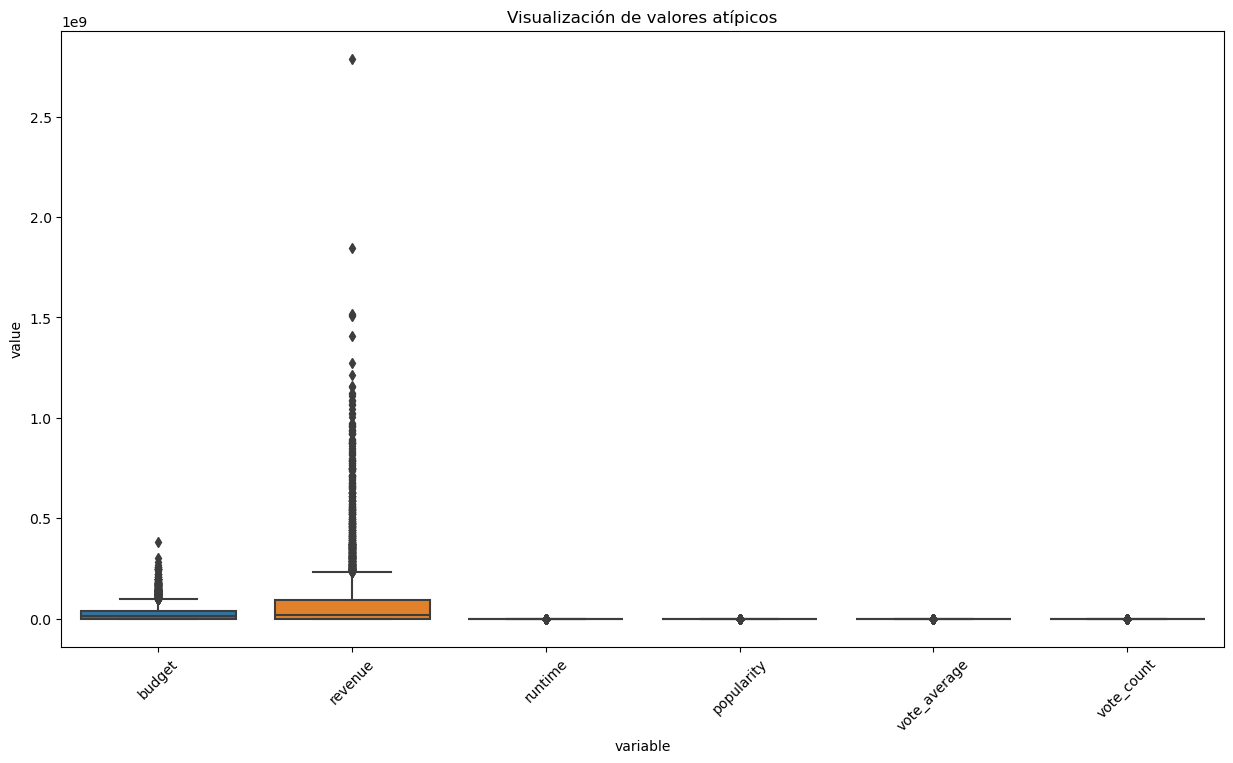

In [15]:
# Visualizar valores atípicos
plt.figure(figsize=(15, 8))
sns.boxplot(x="variable", y="value", data=pd.melt(df_merge[['budget', 'revenue', 'runtime', 'popularity', 'vote_average', 'vote_count']]))
plt.title("Visualización de valores atípicos")
plt.xticks(rotation=45)
plt.show()

/Users/n.c.rodriguez/anaconda3/envs/nico/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


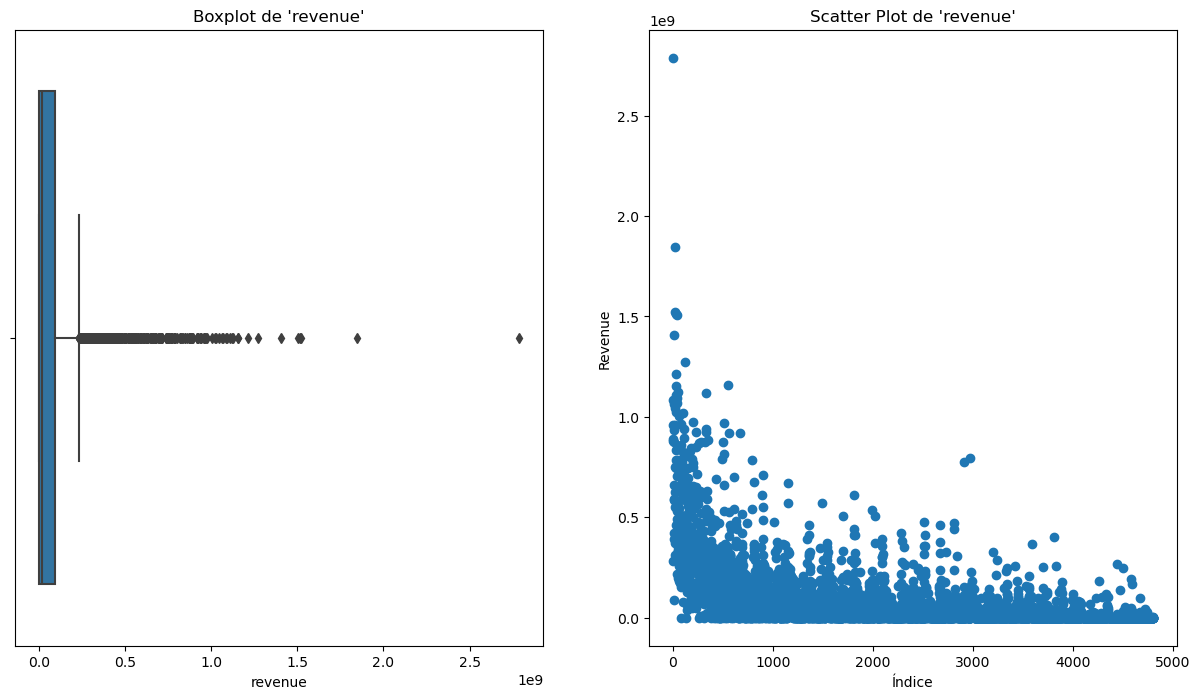

In [16]:
# Visualización con Boxplot y Scatter Plot para 'revenue'
plt.figure(figsize=(15, 8))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x=df_merge['revenue'])
plt.title("Boxplot de 'revenue'")

# Scatter Plot
plt.subplot(1, 2, 2)
plt.scatter(x=df_merge.index, y=df_merge['revenue'])
plt.title("Scatter Plot de 'revenue'")
plt.xlabel("Índice")
plt.ylabel("Revenue")
plt.show()

Parece que en la variable 'revenue' hay un valor muy alto. Se va a analizar dicho registro:

In [17]:
revenue_max = df_merge['revenue'].max()

df_merge[df_merge['revenue'] == revenue_max]

,budget,genres,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


Dicho valor corresponde a la película Avatar, siendo esta una de las películas más taquillera de la historia, por lo que dicho valor tan alto es válido y no se va a eliminar

#### Filtro para tener las películas con un número elevado de votos

In [18]:
# Mediana de los votos y conteo
print(f"La mediana de la nota de las películas es de: {df_merge['vote_average'].median()}")
print(f"La mediana de la cantidad de votos de las películas es de: {df_merge['vote_count'].median()}")

La mediana de la nota de las películas es de: 6.2
La mediana de la cantidad de votos de las películas es de: 236.0


Se van a mantener sólo las películas que tienen un mayor número de votos ya que tendrá calificaciones más fiables. Se usa el percentil 60

In [19]:
percentil_60 = df_merge['vote_count'].quantile(0.60)
print(percentil_60)

371.0


In [20]:
# Cantidad de películas dentro del percentil 75 más votado
print(f"La cantidad de películas que están dentro del percentil 60 son {len(df_merge[df_merge['vote_count']>percentil_60])}")

La cantidad de películas que están dentro del percentil 60 son 1916


In [21]:
# Se hace una copia del DataFrame con el filtro del percentil para no alterar el original
df_merge_percentil = df_merge.copy().loc[df_merge['vote_count'] > percentil_60]

#### 'original_title' vs 'title'

In [22]:
# Bucle para comparar 'original_title' y 'title'
for index, row in df_merge_percentil.iterrows():
    original_title = row['original_title']
    title = row['title']
    
    # Verificar si 'original_title' y 'title' son iguales
    if original_title != title:
        print(f"Índice {index}: 'original_title' ({original_title}) es diferente de 'title' ({title})")

Índice 215: 'original_title' (4: Rise of the Silver Surfer) es diferente de 'title' (Fantastic 4: Rise of the Silver Surfer)
Índice 235: 'original_title' (Astérix aux Jeux Olympiques) es diferente de 'title' (Asterix at the Olympic Games)
Índice 488: 'original_title' (Arthur et les Minimoys) es diferente de 'title' (Arthur and the Invisibles)
Índice 1136: 'original_title' (英雄) es diferente de 'title' (Hero)
Índice 1255: 'original_title' (Lo imposible) es diferente de 'title' (The Impossible)
Índice 1260: 'original_title' (Le fabuleux destin d'Amélie Poulain) es diferente de 'title' (Amélie)
Índice 1357: 'original_title' (葉問3) es diferente de 'title' (Ip Man 3)
Índice 1471: 'original_title' (崖の上のポニョ) es diferente de 'title' (Ponyo)
Índice 1761: 'original_title' (The Neverending Story) es diferente de 'title' (The NeverEnding Story)
Índice 1784: 'original_title' (EverAfter) es diferente de 'title' (Ever After: A Cinderella Story)
Índice 1945: 'original_title' (La migliore offerta) es dif

In [23]:
# Lista de índices que quieres visualizar
indices_a_visualizar = [1136, 1357, 1471, 1987]

# Utilizar el método loc para seleccionar los registros en esos índices
df_merge_percentil[['original_title', 'title']].loc[indices_a_visualizar]

,original_title,title
1136,英雄,Hero
1357,葉問3,Ip Man 3
1471,崖の上のポニョ,Ponyo
1987,ハウルの動く城,Howl's Moving Castle


Dado que la columna 'original_title' contiene caracteres especiales o está en otro idioma al inglés en algunos de los registros, se opta por eliminar dicha columna y mantener la columna 'title'

In [24]:
# Eliminar la columna 'original_title'
df_merge_percentil.drop(['original_title'], axis=1, inplace=True)

#### Exploración más detallada de las columnas

In [25]:
# Lista de columnas a revisar. Estas son columnas que tienen como información una lista de diccionarios
columns_to_explore = ['genres', 'keywords', 'production_companies', 'production_countries', 'spoken_languages', 'cast', 'crew']

# Bucle para explorar cada columna
for column in columns_to_explore:
    print(f"Explorando la columna: {column}\n")
    
    # Imprimir algunos valores de la columna
    sample_values = df_merge_percentil[column].sample(5, random_state=42).tolist()
    
    # Imprimir información
    print(f"Algunos valores de la columna:\n{sample_values}\n")
    print(f"Número total de valores únicos: {df_merge[column].nunique()}\n")
    print("#" * 50 + "\n")

Explorando la columna: genres

Algunos valores de la columna:
['[{"id": 28, "name": "Action"}, {"id": 18, "name": "Drama"}, {"id": 80, "name": "Crime"}]', '[{"id": 80, "name": "Crime"}, {"id": 28, "name": "Action"}, {"id": 35, "name": "Comedy"}]', '[{"id": 35, "name": "Comedy"}, {"id": 80, "name": "Crime"}]', '[{"id": 28, "name": "Action"}, {"id": 53, "name": "Thriller"}]', '[{"id": 10749, "name": "Romance"}, {"id": 35, "name": "Comedy"}]']

Número total de valores únicos: 1175

##################################################

Explorando la columna: keywords

Algunos valores de la columna:
['[{"id": 782, "name": "assassin"}, {"id": 2708, "name": "hitman"}]', '[{"id": 5331, "name": "village"}, {"id": 5638, "name": "arrest"}, {"id": 6149, "name": "police"}, {"id": 9104, "name": "partner"}, {"id": 9826, "name": "murder"}, {"id": 10410, "name": "conspiracy"}, {"id": 12371, "name": "gunfight"}, {"id": 167268, "name": "police force"}, {"id": 167284, "name": "cowboy costume"}, {"id": 20781

Se van a eliminar estas columnas excepto 'genres', 'keywords' y 'cast', ya que tienen información relevante para el objetivo del proyecto

In [26]:
# Lista de columnas a eliminar
columns_to_explore = ['production_companies', 'production_countries', 'spoken_languages', 'crew']

# ELiminación de dichas columnas
df_merge_percentil.drop(columns=columns_to_explore, inplace=True)

In [27]:
df_merge_percentil.head()

,budget,genres,id,keywords,original_language,overview,popularity,release_date,revenue,runtime,status,tagline,title,vote_average,vote_count,cast
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,2009-12-10,2787965087,162.0,Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,"Captain Barbossa, long believed to be dead, ha...",139.082615,2007-05-19,961000000,169.0,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,A cryptic message from Bond’s past sends him o...,107.376788,2015-10-26,880674609,148.0,Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,Following the death of District Attorney Harve...,112.312950,2012-07-16,1084939099,165.0,Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,"John Carter is a war-weary, former military ca...",43.926995,2012-03-07,284139100,132.0,Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c..."


In [28]:
# Valores diferentes de la columna status
df_merge_percentil['status'].value_counts()

status
Released    1916
Name: count, dtype: int64

In [29]:
# Se elimina dicha variable
df_merge_percentil.drop(columns=['status'], inplace=True)

In [30]:
df_merge_percentil[['genres','keywords', 'cast']].head()

,genres,keywords,cast
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""..."
1,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa..."
2,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr..."
3,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba..."
4,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":...","[{""cast_id"": 5, ""character"": ""John Carter"", ""c..."


Se va a extraer la información de las columnas 'genres', 'keywords' y 'cast'

In [31]:
# Función para extraer los valores de la clave "name" y unirlos por espacio
def extract_names(value):
    try:
        #convierte la cadena JSON en una lista de diccionarios
        items = ast.literal_eval(value)
        #extrae los valores de la clave "name"
        names = [item.get("name", "") for item in items]
        #une los valores por espacio
        return " ".join(names)
    except (ValueError, SyntaxError) as e:
        return str(e)

In [32]:
# Uso de la función en las columnas correspondientes
df_merge_percentil['genres'] = df_merge_percentil['genres'].apply(extract_names)
df_merge_percentil['keywords'] = df_merge_percentil['keywords'].apply(extract_names)
df_merge_percentil['cast'] = df_merge_percentil['cast'].apply(extract_names)

In [34]:
# Información después de la transformación
print("DataFrame después de la transformación:")
df_merge_percentil[['genres', 'keywords', 'cast']].head()

DataFrame después de la transformación:


,genres,keywords,cast
0,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,Sam Worthington Zoe Saldana Sigourney Weaver S...
1,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,Johnny Depp Orlando Bloom Keira Knightley Stel...
2,Action Adventure Crime,spy based on novel secret agent sequel mi6 bri...,Daniel Craig Christoph Waltz Léa Seydoux Ralph...
3,Action Crime Drama Thriller,dc comics crime fighter terrorist secret ident...,Christian Bale Michael Caine Gary Oldman Anne ...
4,Action Adventure Science Fiction,based on novel mars medallion space travel pri...,Taylor Kitsch Lynn Collins Samantha Morton Wil...


In [53]:
# Combinación de las columnas overview, genres, keywords y cast en una sola
df_merge_percentil['combined_text'] = df_merge_percentil['overview'] + ' ' + df_merge_percentil['cast'] + ' ' + df_merge_percentil['genres'] + ' ' + df_merge_percentil['keywords']
df_merge_percentil['combined_text'].head()

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: combined_text, dtype: object

### NLP

Se va a realizar una Tokenización y Eliminación de StopWords

In [37]:
#Descarga del modelo de spaCy en inglés al entorno
#!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 4.5 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [44]:
# Descarga de las stopwords y punkt
nltk.download('stopwords')
nltk.download('punkt')
# Carga el modelo de spaCy en inglés
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/n.c.rodriguez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/n.c.rodriguez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [45]:
# Función de tokenización y eliminación de stopwords con NLTLK + Stemming
def preprocessing(text):
    # Tokenización
    tokens = word_tokenize(text)
    
    # Eliminación de stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token.lower() for token in tokens if token.isalpha() and token.lower() not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    return tokens

In [54]:
# Uso de la función preprocessing
df_merge_percentil['combined_text_preprocessed'] = df_merge_percentil['combined_text'].apply(preprocessing)

In [55]:
df_merge_percentil['combined_text_preprocessed'].head()

0    [centuri, parapleg, marin, dispatch, moon, pan...
1    [captain, barbossa, long, believ, dead, come, ...
2    [cryptic, messag, bond, past, send, trail, unc...
3    [follow, death, district, attorney, harvey, de...
4    [john, carter, former, militari, captain, inex...
Name: combined_text_preprocessed, dtype: object